# Calculating Luminosities and Luminosity Functions (at 1.4 GHz)

First, let's install some packages.

In [1]:
!pip install scikit-learn==0.23.2

!pip install "tune-sklearn>=0.2.1"
!pip install "scikit-optimize>=0.8.1"

!pip install ppscore

!pip install sklearn-som
!pip install umap
!pip install trimap
!pip install "pacmap==0.4"

!pip install cmasher
!pip install colorcet
!pip install mpl-scatter-density

# Only for GPU usage
# !pip uninstall lightgbm -y
# !pip install --upgrade lightgbm
# install lightgbm GPU
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

# !pip install --upgrade "xgboost>=1.1.0"
# !pip install --upgrade "catboost>=0.23.2"
!pip install --upgrade shap
!pip install pycaret

     |████████████████████████████████| 6.8 MB 4.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 51.5 MB 22 kB/s 
     |████████████████████████████████| 127 kB 54.8 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 10.1 MB 31.4 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 72 kB 517 kB/s 
     |████████████████████████████████| 1.3 MB 27.1 MB/s 
     |████████████████████████████████| 3.1 MB 34.2 MB/s 
     |████████████████████████████████| 124 kB 48.3 MB/s 
     |████████████████████████████████| 142 kB 72.9 MB/s 
     |████████████████████████████████| 294 kB 54.0 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
  

We need to restart Google's runtime for updating all internal links.

In [ ]:
import os
os._exit(00)

Importing the packages we will use.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mpl_scatter_density
from scipy import optimize
from astropy.table import Table, join
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
import ppscore as pps
import seaborn as sns
import cmasher as cmr
import colorcet as cc
import getpass
# import pacmap
# import umap
# import trimap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn_som import som
import pandas as pd
import re
import shap
# import pycaret.regression as pyr
# import pycaret.classification as pyc
# import missingno as msno
import os
import subprocess

Small function for normalization of colorbars.

In [2]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

Configuration snippets for texts in plots with too-crowded backgrounds.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

---

## Load data

We will use predicted redshifts and spectral classes from both DES (Dark Energy Survey) and SM (Sky Mapper).

In [4]:
file_name_DES = 'RACS_DES_classPred_zPred_df.csv'
file_name_SM  = 'RACS_SM_predicts_z_spec_class.csv'

Downloading datasets.

In [5]:
if not os.path.exists(file_name_DES):
    subprocess.run(['wget', '--no-check-certificate',\
                    'https://docs.google.com/uc?export=download&id=1jxEMlQxb8kk3PlF6e8LUgA4NuTujciE3',\
                    '-O', file_name_DES], check=True, text=True)

In [6]:
if not os.path.exists(file_name_SM):
    subprocess.run(['wget', '--no-check-certificate',\
                    'https://docs.google.com/uc?export=download&id=152dAw9px9A6DiZP4jiviKiT_RSnbKNTp',\
                    '-O', file_name_SM], check=True, text=True)

In [7]:
catalog_full_DES_df = pd.read_csv(file_name_DES)
catalog_full_SM_df  = pd.read_csv(file_name_SM)

Get stats from datasets.

In [8]:
catalog_full_DES_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175754 entries, 0 to 175753
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           175754 non-null  int64  
 1   Unnamed: 0.1         175754 non-null  int64  
 2   MAG_G                175754 non-null  float64
 3   MAG_R                175754 non-null  float64
 4   MAG_I                175754 non-null  float64
 5   MAG_Z                175754 non-null  float64
 6   J_VISTA              175754 non-null  float64
 7   KS_VISTA             175754 non-null  float64
 8   W1MAG                175754 non-null  float64
 9   W2MAG                175754 non-null  float64
 10  flux_int             175754 non-null  float64
 11  color_GmR            175754 non-null  float64
 12  color_RmZ            175754 non-null  float64
 13  color_ZmJ            175754 non-null  float64
 14  color_JmKs           175754 non-null  float64
 15  color_KsmW1      

In [9]:
catalog_full_SM_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92013 entries, 0 to 92012
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        92013 non-null  int64  
 1   Unnamed: 0.1      92013 non-null  int64  
 2   catalogue_id      92013 non-null  int64  
 3   n_components      92013 non-null  int64  
 4   flux_int          92013 non-null  float64
 5   flux_peak         92013 non-null  float64
 6   quality_level     92013 non-null  object 
 7   SOURCEID_VISTA    92013 non-null  int64  
 8   W1MAG             92013 non-null  float64
 9   W2MAG             92013 non-null  float64
 10  J_VISTA           92013 non-null  float64
 11  KS_VISTA          92013 non-null  float64
 12  PSTAR_VISTA       92013 non-null  float64
 13  MAG_U             92013 non-null  float64
 14  MAG_G             92013 non-null  float64
 15  MAG_R             92013 non-null  float64
 16  MAG_I             92013 non-null  float6

## Obtain fluxes and luminosities as 1.4 GHz

---

We assume that, in the radio regime, fluxes are proportional to frequency as:  

$$
S_{\nu} \propto \nu^{-\alpha}
$$  

We will assume a spectral index of $\alpha = -0.8$.

In [10]:
alpha = -0.8

RACS has a sensitivity limit of $0.25$ mJy. We will use sources that have a flux three times that or higher.

In [11]:
limit_flux = 0.75  # mJy, 3 x 0.25 mJy

We will assume a $\Lambda$-CDM cosmology.

In [12]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Our original radio measurements are in magnitude units. We need to convert them into fluxes (mJy).

In [13]:
radio_flx_DES     = (catalog_full_DES_df.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy)
radio_flx_SM      = (catalog_full_SM_df.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy)

In [14]:
catalog_full_DES_df['flux_int_mJy'] = radio_flx_DES
catalog_full_SM_df['flux_int_mJy']  = radio_flx_SM

For the sake of using only extragalactic sources, we discard sources classified as stars. Also at this point, we discard sources with fluxes below our limit.

In [15]:
filter_DES = np.array(catalog_full_DES_df.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(catalog_full_DES_df.loc[:, 'classLabel'] != 0)
filter_SM  = np.array(catalog_full_SM_df.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(catalog_full_SM_df.loc[:, 'spec_class_pred'] != 0)

In [16]:
catalog_full_DES_df = catalog_full_DES_df.loc[filter_DES]
catalog_full_SM_df  = catalog_full_SM_df.loc[filter_SM]

From Astropy's cosmology package, we compute luminosity distances, in meters.

In [17]:
lum_distances_DES = cosmo.luminosity_distance(catalog_full_DES_df.loc[:, 'zPred']).to(u.m).value
lum_distances_SM  = cosmo.luminosity_distance(catalog_full_SM_df.loc[:, 'z_pred']).to(u.m).value

For future comparisons, we need to calculate fluxes and luminosities at $1.4$ GHz. From RACS, we have data at $887.5$ MHz.  

We will use the following relation for that  

$$
S_{a} = S_{b} \times \left(\frac{\nu_{a}}{\nu_{b}}\right)^{2}
$$

In [18]:
radio_flx_DES_14  = (catalog_full_DES_df.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha
radio_flx_SM_14   = (catalog_full_SM_df.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

Now, we can compute $1.4$ GHz luminosities.  

$$
\mathrm{L}_{1.4\mathrm{GHz}} = \frac{4 \pi D_{l}^{2} [\mathrm{m}^{2}] S_{1.4\mathrm{GHz}} [\mathrm{mJy}] \times 10^{-3} \times 10^{-26}}{(1 + z)^{1 + \alpha}} [\mathrm{W/Hz}]
$$

In [19]:
luminosity_DES   = 4 * np.pi * lum_distances_DES**2 * radio_flx_DES_14 * 1e-3  * 1e-26 /\
                     (1 + catalog_full_DES_df.loc[:, 'zPred'])**(1 + alpha)  # in W/Hz
luminosity_SM    = 4 * np.pi * lum_distances_SM**2  * radio_flx_SM_14  * 1e-3  * 1e-26 /\
                     (1 + catalog_full_SM_df.loc[:, 'z_pred'])**(1 + alpha)  # in W/Hz

In [20]:
catalog_full_DES_df['flux_int_mJy_14'] = radio_flx_DES_14
catalog_full_SM_df['flux_int_mJy_14']  = radio_flx_SM_14

In [21]:
catalog_full_DES_df['lum_racs'] = luminosity_DES
catalog_full_SM_df['lum_racs']  = luminosity_SM

As a way to clean the samples and their predictions, we will assume that all sources with a $1.4$ GHz luminosity higher than $10^{25}$ W/Hz is an AGN, and we will change its predicted spectroscopic class.

In [22]:
filt_class_lum_DES = np.array(catalog_full_DES_df['lum_racs'] > 1e25)
filt_class_lum_SM  = np.array(catalog_full_SM_df['lum_racs'] > 1e25)

In [23]:
catalog_full_DES_df.loc[:, 'classLabel'].mask(filt_class_lum_DES, other=1, inplace=True)
catalog_full_SM_df.loc[:, 'spec_class_pred'].mask(filt_class_lum_SM, other=1, inplace=True)

We can, now, plot the distributions of luminosities as a function of redshift and class.

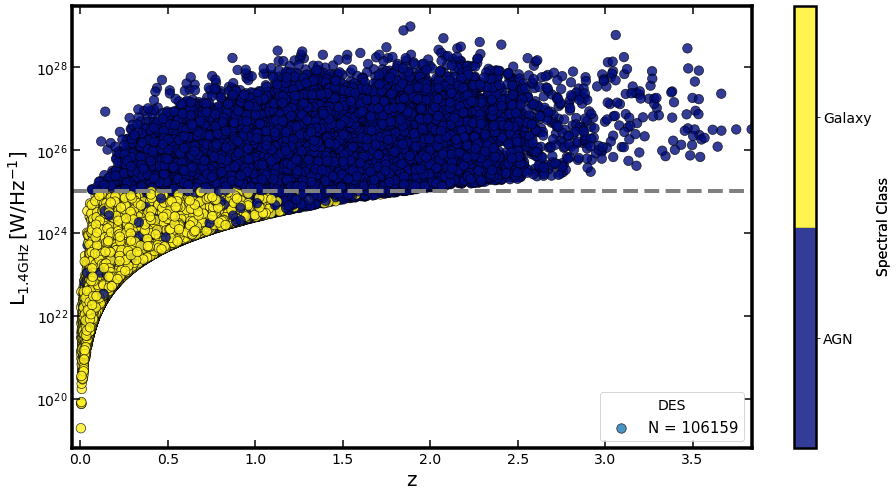

In [24]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

norm_f = mcolors.LogNorm(vmin=1e-2, vmax=1e6)

sc_p = ax1.scatter(catalog_full_DES_df.loc[:, 'zPred'].sample(frac=1, random_state=42),\
            catalog_full_DES_df.loc[:, 'lum_racs'].sample(frac=1, random_state=42),\
            c=catalog_full_DES_df.loc[:, 'classLabel'].sample(frac=1, random_state=42),\
            s=90, plotnonfinite=True, linewidths=0.7, cmap=cm.get_cmap('cet_bgy', 2),\
            edgecolors='k', alpha=0.8, label=f'N = {np.sum(np.isfinite(catalog_full_DES_df.loc[:, "lum_racs"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(sc_p, ticks=[1.25, 1.75])
# clb             = plt.colorbar(sc_p, ticks=[0.33, 1.0, 1.66])
# clb.set_ticks([0.33, 1.0, 1.66])
clb.ax.set_yticklabels(['AGN', 'Galaxy'])
# clb.ax.set_yticklabels(['Star', 'AGN', 'Galaxy'])
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}}\, [\mathrm{mJy}]$', size=14, path_effects=pe2)
clb.set_label('Spectral Class', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=catalog_full_DES_df.loc[:, 'zPred'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='DES', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

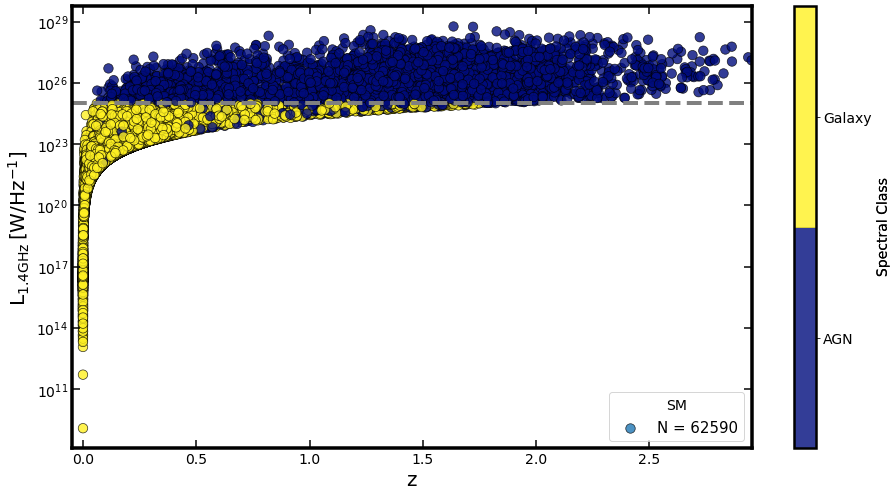

In [25]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

norm_f = mcolors.LogNorm(vmin=1e-2, vmax=1e6)

sc_p = ax1.scatter(catalog_full_SM_df.loc[:, 'z_pred'].sample(frac=1, random_state=42),\
            catalog_full_SM_df.loc[:, 'lum_racs'].sample(frac=1, random_state=42),\
            c=catalog_full_SM_df.loc[:, 'spec_class_pred'].sample(frac=1, random_state=42),\
            s=90, plotnonfinite=True, linewidths=0.7, cmap=cm.get_cmap('cet_bgy', 2),\
            edgecolors='k', alpha=0.8, label=f'N = {np.sum(np.isfinite(catalog_full_SM_df.loc[:, "lum_racs"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

# clb             = plt.colorbar(sc_p, ticks=[0.33, 1.0, 1.66])
clb             = plt.colorbar(sc_p, ticks=[1.25, 1.75])
# clb.set_ticks([0.33, 1.0, 1.66])
clb.ax.set_yticklabels(['AGN', 'Galaxy'])
# clb.ax.set_yticklabels(['Star', 'AGN', 'Galaxy'])
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('Spectral Class', size=14, path_effects=pe2)
clb.set_label('Spectral Class', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=catalog_full_SM_df.loc[:, 'z_pred'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='SM', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

All-NaN slice encountered
All-NaN slice encountered


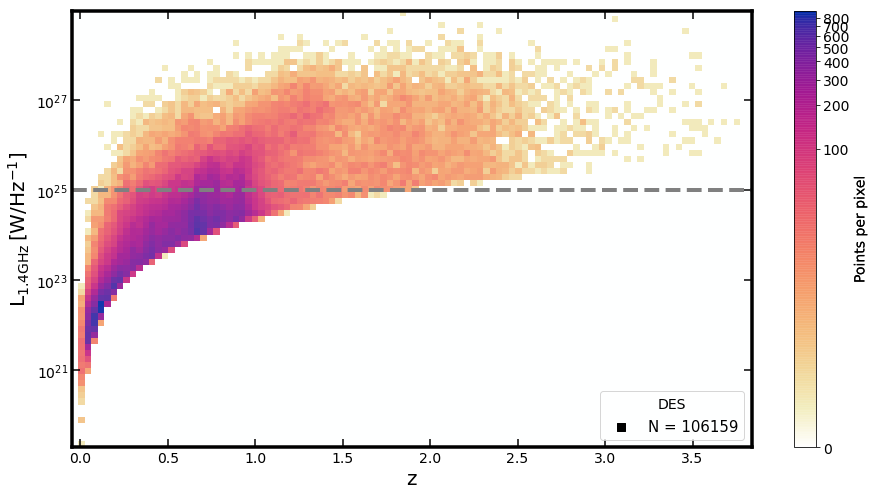

In [26]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log', projection='scatter_density')


norm = ImageNormalize(stretch=LogStretch())

dens_1 = ax1.scatter_density(catalog_full_DES_df.loc[:, 'zPred'],\
            catalog_full_DES_df.loc[:, 'lum_racs'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=12, norm=norm, alpha=0.93)

# dens_1 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==2, 'lum_racs'],\
#             color='b', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_2 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==1, 'lum_racs'],\
#             color='r', zorder=0, dpi=12, norm=norm, alpha=0.53)
# dens_3 = ax1.scatter_density(catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'zPred'],\
#             catalog_full_DES_df.loc[catalog_full_DES_df.loc[:, 'classLabel']==0, 'lum_racs'],\
#             color='g', zorder=0, dpi=12, norm=norm, alpha=0.53)

# False point for legend
ax1.scatter([0], [0], marker='s', s=70, c='k',\
            label=f'N = {np.sum(np.isfinite(catalog_full_DES_df.loc[:, "lum_racs"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
# clb.ax.set_ylabel('Points per pixel', size=14, path_effects=pe2)
clb.set_label('Points per pixel', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=catalog_full_DES_df.loc[:, 'zPred'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='DES', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

All-NaN slice encountered
All-NaN slice encountered


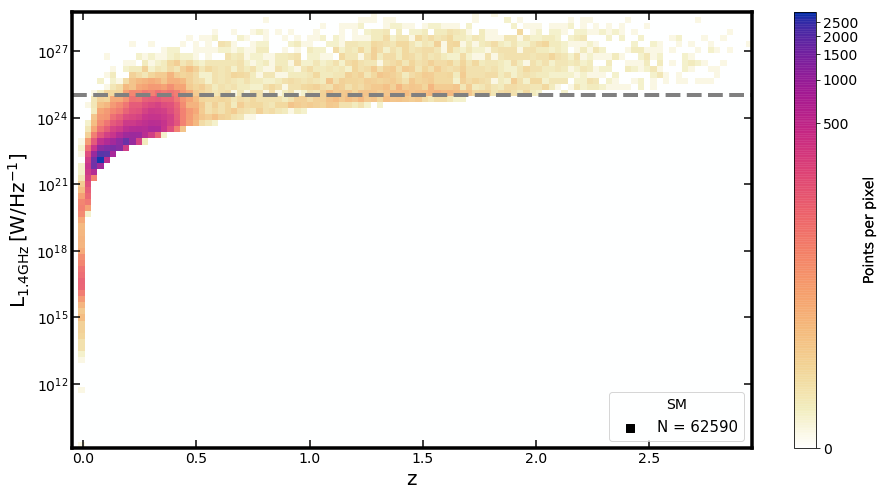

In [27]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log', projection='scatter_density')


norm = ImageNormalize(stretch=LogStretch())

dens_1 = ax1.scatter_density(catalog_full_SM_df.loc[:, 'z_pred'],\
            catalog_full_SM_df.loc[:, 'lum_racs'],\
            cmap=plt.get_cmap('cet_CET_L17'), zorder=0, dpi=12, norm=norm, alpha=0.93)

# False point for legend
ax1.scatter([0], [0], marker='s', s=70, c='k',\
            label=f'N = {np.sum(np.isfinite(catalog_full_SM_df.loc[:, "lum_racs"]))}')

ax1.axhline(y=1e25, ls='--', color='Gray', lw=4)

clb             = plt.colorbar(dens_1)
clb.ax.tick_params(labelsize=14)
clb.outline.set_linewidth(2.5)
clb.set_label('Points per pixel', size=14, path_effects=pe2)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('z', size=20)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.set_xlim(left=-0.05, right=catalog_full_SM_df.loc[:, 'z_pred'].max())
# ax1.set_ylim(bottom=1e23, top=2e29)
ax1.legend(loc=4, fontsize=15, title='SM', title_fontsize=14)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

---

## Luminosity functions

For obtaining luminosity functions, we will use the $\mathrm{V}_{\mathrm{max}}$ method. A nice practical example can be seen in [this link](http://www.star.bris.ac.uk/sxp/galaxyproblem2ans.pdf).

With this method, the luminosity function is defined as:  

$$
\phi = \frac{1}{\Delta \log{\mathrm{L}}} \times \sum_{i} \frac{1}{\mathrm{V}_{\mathrm{max}, i}}
$$

And its uncertainty is obtained as follows:

$$
\sigma_{\phi} = \frac{1}{\Delta \log{\mathrm{L}}} \times \sqrt{\sum_{i} \frac{1}{\mathrm{V}_{\mathrm{max}, i}^{2}}}
$$

What we need to obtain, initially, is the maximum redshift value at which each source would still be seen by RACS.  

In order to get that value, we need to use the luminosities we already have and the predicted redshifts.  

Theoretically, at that $z_{\mathrm{max}}$ value, our sources (with a fixed luminosity) will have a flux equal to $\mathrm{S}_{lim} = 0.75$ mJy.

That can be seen in the following expression:  

$$
\mathrm{L}_{1.4\mathrm{GHz}} = \frac{4 \pi D_{l}^{2}(z_{\mathrm{max}}) \mathrm{S}_{\mathrm{lim}}^{\mathrm{RACS}}}{(1 + z_{\mathrm{max}})^{1 + \alpha}} \times \left(\frac{1.4\mathrm{GHz}}{887.5\mathrm{MHz}}\right)^{\alpha}
$$

We can manipulate this expression a bit given that we know an expression for $\mathrm{L}_{1.4\mathrm{GHz}}$  

$$
\frac{4 \pi D_{l}^{2} \mathrm{S}_{887.5\mathrm{MHz}}}{(1 + z)^{1 + \alpha}} \times \left(\frac{1.4\mathrm{GHz}}{887.5\mathrm{MHz}}\right)^{\alpha} = \frac{4 \pi D_{l}^{2}(z_{\mathrm{max}}) \mathrm{S}_{\mathrm{lim}}^{\mathrm{RACS}}}{(1 + z_{\mathrm{max}})^{1 + \alpha}} \times \left(\frac{1.4\mathrm{GHz}}{887.5\mathrm{MHz}}\right)^{\alpha}
$$


$$
\frac{D_{l}^{2} \mathrm{S}_{887.5\mathrm{MHz}}}{(1 + z)^{1 + \alpha}} = \frac{D_{l}^{2}(z_{\mathrm{max}}) \mathrm{S}_{\mathrm{lim}}^{\mathrm{RACS}}}{(1 + z_{\mathrm{max}})^{1 + \alpha}}
$$

$$
\frac{(1 + z_{\mathrm{max}})^{1 + \alpha}}{D_{l}^{2}(z_{\mathrm{max}})} = \frac{(1 + z)^{1 + \alpha}}{D_{l}^{2}} \times \frac{\mathrm{S}_{\mathrm{lim}}^{\mathrm{RACS}}}{\mathrm{S}_{887.5\mathrm{MHz}}}
$$

So, we need to solve this expression for $z_{\mathrm{max}}$. But it is not so simple since the luminosity function is not easily invertible.  

What we can do is use `Scipy` to find the roots of the following function:  

$$
f(z_{\mathrm{max}}) = \frac{(1 + z_{\mathrm{max}})^{1 + \alpha}}{D_{l}^{2}(z_{\mathrm{max}})} - \frac{(1 + z)^{1 + \alpha}}{D_{l}^{2}} \times \frac{\mathrm{S}_{\mathrm{lim}}^{\mathrm{RACS}}}{\mathrm{S}_{887.5\mathrm{MHz}}}
$$

The last term is constant for each source, so the algorithm can focus on the first term only.

Let's save that last term for each element in our datasets.

In [28]:
catalog_full_DES_df['inter_val'] = ((1 + (1 + catalog_full_DES_df.loc[:, 'zPred'])**(1 + alpha)) / lum_distances_DES**2) *\
         (limit_flux / catalog_full_DES_df['flux_int_mJy'])

catalog_full_SM_df['inter_val'] = ((1 + (1 + catalog_full_SM_df.loc[:, 'z_pred'])**(1 + alpha)) / lum_distances_SM**2) *\
         (limit_flux / catalog_full_SM_df['flux_int_mJy'])

Now, we can define the function to use for the root-finding algorithm.

In [29]:
def func(z, factor):
    return (1 + z)**(1 + alpha) / cosmo.luminosity_distance(z).to(u.m).value**2 - factor

Finally, we can tell `scipy` to find the roots of the function.  
We are doing this inside of `pandas` to save some running time.  
`optimize.root` takes, here, three parameters. The first, the function we want to study. The second, a first guess for the redshift (we will use the predicted redshift, it could be any other better guess). And, finally, the other argument in the function, the second constant term.

In [30]:
catalog_full_DES_df['max_z'] = catalog_full_DES_df.apply(lambda row: optimize.root(func, row['zPred'], args=(row['inter_val'], )).x[0], axis=1)

In [31]:
catalog_full_SM_df['max_z'] = catalog_full_SM_df.apply(lambda row: optimize.root(func, row['z_pred'], args=(row['inter_val'], )).x[0], axis=1)

Now, we have our maximum redshifts for all the sources in the datasets. We can see some basic statistics.

In [32]:
catalog_full_DES_df.loc[:, 'max_z'].describe()

count    106159.000000
mean          1.510662
std           2.926079
min           0.002897
25%           0.363137
50%           0.764108
75%           1.426554
max         115.777554
Name: max_z, dtype: float64

In [33]:
catalog_full_SM_df.loc[:, 'max_z'].describe()

count    62590.000000
mean         0.653398
std          2.381491
min         -0.000398
25%          0.094776
50%          0.193309
75%          0.433550
max         88.511261
Name: max_z, dtype: float64

The next step in the process for our Luminosity Functions is obtaining the maximum volume each source can be detected.  

First, from these max redshifts, we compute the max luminosity distances.

In [34]:
catalog_full_DES_df['d_max_mpc'] = cosmo.luminosity_distance(catalog_full_DES_df.loc[:, 'max_z']).to(u.Mpc).value
catalog_full_SM_df['d_max_mpc'] = cosmo.luminosity_distance(catalog_full_SM_df.loc[:, 'max_z']).to(u.Mpc).value

Each source has been detected in a particular survey, and these surveys have a certain sky coverage which is measured in square degrees. You can see these values in Table 1 of [this article](https://arxiv.org/pdf/2103.09257.pdf).

In [35]:
DES_area = 4900  # sq deg
SM_area  = 9300  # sq deg  # old value: 17000

With these areas, we can compute the maximum volume each of our sources might have been detected (in $\mathrm{Mpc}^{3}$). We are using the fact that $1 \mathrm{deg}^{2} = \frac{1}{3282} \mathrm{sr}$.

In [36]:
catalog_full_DES_df['max_vol_mpc3'] = DES_area * catalog_full_DES_df['d_max_mpc']**3 / 3 / 3282  # 1 square degree is 1/3282 steradians
catalog_full_SM_df['max_vol_mpc3']  = SM_area * catalog_full_SM_df['d_max_mpc']**3 / 3 / 3282  # 1 square degree is 1/3282 steradians

Next, we invert these values to have $1/\mathrm{V}_{\mathrm{max}}$

In [37]:
catalog_full_DES_df['1_vmax'] = 1 / catalog_full_DES_df['max_vol_mpc3']
catalog_full_SM_df['1_vmax']  = 1 / catalog_full_SM_df['max_vol_mpc3']

We also compute $1 / \mathrm{V}_{\mathrm{max}}^{2}$ for the error bars in future plots.

In [38]:
catalog_full_DES_df['1_vmax2'] = 1 / catalog_full_DES_df['max_vol_mpc3']**2
catalog_full_SM_df['1_vmax2']  = 1 / catalog_full_SM_df['max_vol_mpc3']**2

In [39]:
catalog_full_DES_df['1_vmax'].describe()

count    1.061590e+05
mean     3.177311e-08
std      3.315341e-06
min      6.148770e-19
25%      1.863808e-12
50%      1.883678e-11
75%      2.757472e-10
max      1.045482e-03
Name: 1_vmax, dtype: float64

Following with the process, now we want to separate our $\mathrm{V}_{\mathrm{max}}$ values in bins of luminosity and redshift.

First, we create luminosity bins. They could be any array of values that suit your dataset. Check the ranges your luminosities have before creating them.

In [99]:
bins_size_dex = 0.1  # Log(luminosity) bin size

cut_bins_DES = np.logspace(19, 29, int((29 - 19)/bins_size_dex + 1))
# cut_bins_DES = [1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25, 1e26,\
#                 1e27, 1e28, 1e29]
cut_bins_SM  = np.logspace(9, 29, int((29 - 9)/bins_size_dex + 1))
# cut_bins_SM  = [1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16,\
#                 1e17, 1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25,\
#                 1e26, 1e27, 1e28, 1e29]

With the help of `pandas` we add a column to our datasets flagging each source to which luminosity bin they belong to.

In [100]:
catalog_full_DES_df['cut_lums'] = pd.cut(catalog_full_DES_df.loc[:, 'lum_racs'],\
                                             bins=cut_bins_DES)
catalog_full_SM_df['cut_lums']  = pd.cut(catalog_full_SM_df.loc[:, 'lum_racs'],\
                                             bins=cut_bins_SM)

These are the luminosity distributions after the binning.

In [101]:
catalog_full_DES_df.loc[:, 'cut_lums'].value_counts(sort=False)

(1e+19, 1.2589254117941713e+19]                     0
(1.2589254117941713e+19, 1.5848931924611109e+19]    0
(1.5848931924611109e+19, 1.9952623149688828e+19]    1
(1.9952623149688828e+19, 2.511886431509572e+19]     0
(2.511886431509572e+19, 3.162277660168379e+19]      0
                                                   ..
(3.1622776601683795e+28, 3.981071705534986e+28]     1
(3.981071705534986e+28, 5.011872336272756e+28]      2
(5.011872336272756e+28, 6.309573444801943e+28]      1
(6.309573444801943e+28, 7.943282347242789e+28]      1
(7.943282347242789e+28, 1e+29]                      1
Name: cut_lums, Length: 100, dtype: int64

In [102]:
catalog_full_SM_df.loc[:, 'cut_lums'].value_counts(sort=False)

(1000000000.0, 1258925411.794]                     1
(1258925411.794, 1584893192.461]                   0
(1584893192.461, 1995262314.969]                   0
(1995262314.969, 2511886431.51]                    0
(2511886431.51, 3162277660.168]                    0
                                                  ..
(3.1622776601683795e+28, 3.981071705534986e+28]    2
(3.981071705534986e+28, 5.011872336272756e+28]     0
(5.011872336272756e+28, 6.309573444801943e+28]     2
(6.309573444801943e+28, 7.943282347242854e+28]     0
(7.943282347242854e+28, 1e+29]                     0
Name: cut_lums, Length: 200, dtype: int64

Finally, we can create new `pandas` DataFrames with the sums of all features by luminosity bin.  

We can create separate objects for galaxies and AGN and different redshift bins.  

We will use, in principle, two redshift bins $[0.1, 0.4]$ and $[1.0, 1.3]$ to match the examples from Israel's slides (and [this article](https://iopscience.iop.org/article/10.1088/1742-6596/1231/1/012005/pdf)).

In [103]:
filter_z0_DES = np.array(catalog_full_DES_df.loc[:, 'zPred'] >= 0.1) & np.array(catalog_full_DES_df.loc[:, 'zPred'] <= 0.4)
filter_z1_DES = np.array(catalog_full_DES_df.loc[:, 'zPred'] >= 1.0) & np.array(catalog_full_DES_df.loc[:, 'zPred'] <= 1.3)
filter_z0_SM  = np.array(catalog_full_SM_df.loc[:, 'z_pred'] >= 0.1) & np.array(catalog_full_SM_df.loc[:, 'z_pred'] <= 0.4)
filter_z1_SM  = np.array(catalog_full_SM_df.loc[:, 'z_pred'] >= 1.0) & np.array(catalog_full_SM_df.loc[:, 'z_pred'] <= 1.3)

filter_AGN_DES = np.array(catalog_full_DES_df.loc[:, 'classLabel'] == 1)
filter_gal_DES = np.array(catalog_full_DES_df.loc[:, 'classLabel'] == 2)
filter_AGN_SM  = np.array(catalog_full_SM_df.loc[:, 'spec_class_pred'] == 1)
filter_gal_SM  = np.array(catalog_full_SM_df.loc[:, 'spec_class_pred'] == 2)

Here we add up all the columns (and in particular, the $1/\mathrm{V}_\mathrm{max}$) for each z-L bin.

In [104]:
DES_AGN_sumed_bins_z0 = catalog_full_DES_df.loc[filter_AGN_DES & filter_z0_DES].groupby('cut_lums').sum()
DES_gal_sumed_bins_z0 = catalog_full_DES_df.loc[filter_gal_DES & filter_z0_DES].groupby('cut_lums').sum()
SM_AGN_sumed_bins_z0  = catalog_full_SM_df.loc[filter_AGN_SM & filter_z0_SM].groupby('cut_lums').sum()
SM_gal_sumed_bins_z0  = catalog_full_SM_df.loc[filter_gal_SM & filter_z0_SM].groupby('cut_lums').sum()

DES_AGN_sumed_bins_z1 = catalog_full_DES_df.loc[filter_AGN_DES & filter_z1_DES].groupby('cut_lums').sum()
DES_gal_sumed_bins_z1 = catalog_full_DES_df.loc[filter_gal_DES & filter_z1_DES].groupby('cut_lums').sum()
SM_AGN_sumed_bins_z1  = catalog_full_SM_df.loc[filter_AGN_SM & filter_z1_SM].groupby('cut_lums').sum()
SM_gal_sumed_bins_z1  = catalog_full_SM_df.loc[filter_gal_SM & filter_z1_SM].groupby('cut_lums').sum()

We add an extra column with the number of elements per bin for drawing error bars in our plots.

In [105]:
DES_AGN_sumed_bins_z0['size'] = catalog_full_DES_df.loc[filter_AGN_DES & filter_z0_DES, 'cut_lums'].value_counts(sort=False)
DES_gal_sumed_bins_z0['size'] = catalog_full_DES_df.loc[filter_gal_DES & filter_z0_DES, 'cut_lums'].value_counts(sort=False)
SM_AGN_sumed_bins_z0['size']  = catalog_full_SM_df.loc[filter_AGN_SM & filter_z0_SM, 'cut_lums'].value_counts(sort=False)
SM_gal_sumed_bins_z0['size']  = catalog_full_SM_df.loc[filter_gal_SM & filter_z0_SM, 'cut_lums'].value_counts(sort=False)

DES_AGN_sumed_bins_z1['size'] = catalog_full_DES_df.loc[filter_AGN_DES & filter_z1_DES, 'cut_lums'].value_counts(sort=False)
DES_gal_sumed_bins_z1['size'] = catalog_full_DES_df.loc[filter_gal_DES & filter_z1_DES, 'cut_lums'].value_counts(sort=False)
SM_AGN_sumed_bins_z1['size']  = catalog_full_SM_df.loc[filter_AGN_SM & filter_z1_SM, 'cut_lums'].value_counts(sort=False)
SM_gal_sumed_bins_z1['size']  = catalog_full_SM_df.loc[filter_gal_SM & filter_z1_SM, 'cut_lums'].value_counts(sort=False)

In [106]:
DES_AGN_sumed_bins_z0['delta_L'] = (DES_AGN_sumed_bins_z0.index.categories.right - DES_AGN_sumed_bins_z0.index.categories.left).values
DES_gal_sumed_bins_z0['delta_L'] = (DES_gal_sumed_bins_z0.index.categories.right - DES_gal_sumed_bins_z0.index.categories.left).values
SM_AGN_sumed_bins_z0['delta_L']  = (SM_AGN_sumed_bins_z0.index.categories.right - SM_AGN_sumed_bins_z0.index.categories.left).values
SM_gal_sumed_bins_z0['delta_L']  = (SM_gal_sumed_bins_z0.index.categories.right - SM_gal_sumed_bins_z0.index.categories.left).values

DES_AGN_sumed_bins_z1['delta_L'] = (DES_AGN_sumed_bins_z1.index.categories.right - DES_AGN_sumed_bins_z1.index.categories.left).values
DES_gal_sumed_bins_z1['delta_L'] = (DES_gal_sumed_bins_z1.index.categories.right - DES_gal_sumed_bins_z1.index.categories.left).values
SM_AGN_sumed_bins_z1['delta_L']  = (SM_AGN_sumed_bins_z1.index.categories.right - SM_AGN_sumed_bins_z1.index.categories.left).values
SM_gal_sumed_bins_z1['delta_L']  = (SM_gal_sumed_bins_z1.index.categories.right - SM_gal_sumed_bins_z1.index.categories.left).values

In [107]:
DES_AGN_sumed_bins_z0.loc[:, '1_vmax']

cut_lums
(1e+19, 1.2589254117941713e+19]                     0.0
(1.2589254117941713e+19, 1.5848931924611109e+19]    0.0
(1.5848931924611109e+19, 1.9952623149688828e+19]    0.0
(1.9952623149688828e+19, 2.511886431509572e+19]     0.0
(2.511886431509572e+19, 3.162277660168379e+19]      0.0
                                                   ... 
(3.1622776601683795e+28, 3.981071705534986e+28]     0.0
(3.981071705534986e+28, 5.011872336272756e+28]      0.0
(5.011872336272756e+28, 6.309573444801943e+28]      0.0
(6.309573444801943e+28, 7.943282347242789e+28]      0.0
(7.943282347242789e+28, 1e+29]                      0.0
Name: 1_vmax, Length: 100, dtype: float64

In [108]:
np.log10(DES_AGN_sumed_bins_z0.loc[:, 'delta_L'])

cut_lums
(1e+19, 1.2589254117941713e+19]                     18.413175
(1.2589254117941713e+19, 1.5848931924611109e+19]    18.513175
(1.5848931924611109e+19, 1.9952623149688828e+19]    18.613175
(1.9952623149688828e+19, 2.511886431509572e+19]     18.713175
(2.511886431509572e+19, 3.162277660168379e+19]      18.813175
                                                      ...    
(3.1622776601683795e+28, 3.981071705534986e+28]     27.913175
(3.981071705534986e+28, 5.011872336272756e+28]      28.013175
(5.011872336272756e+28, 6.309573444801943e+28]      28.113175
(6.309573444801943e+28, 7.943282347242789e+28]      28.213175
(7.943282347242789e+28, 1e+29]                      28.313175
Name: delta_L, Length: 100, dtype: float64

We can, finally, plot our results.

divide by zero encountered in log10
invalid value encountered in log10
invalid value encountered in subtract
divide by zero encountered in log10
divide by zero encountered in log10


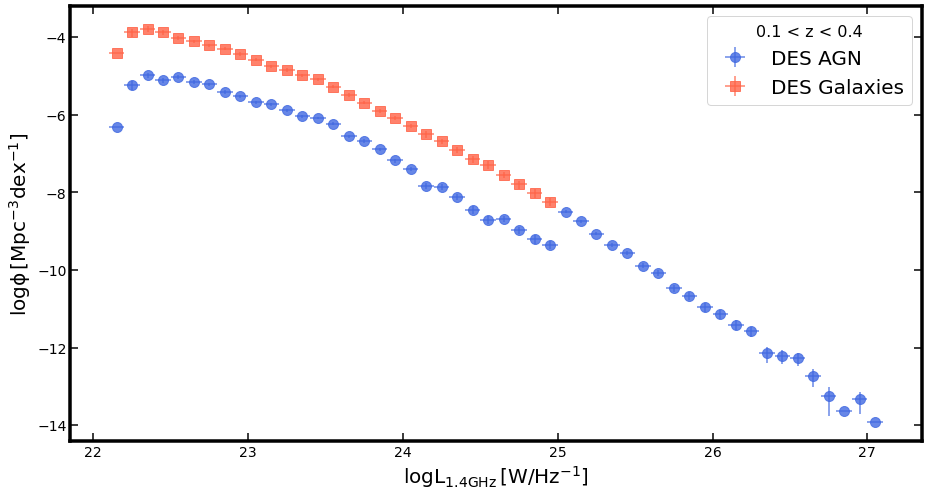

In [117]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

y_errs = np.array([np.log10(DES_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
         np.log10(DES_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex -\
                  np.sqrt(DES_AGN_sumed_bins_z0.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex),\
          np.log10(np.sqrt(DES_AGN_sumed_bins_z0.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex +\
                   DES_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
          np.log10(DES_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex)])

ax1.errorbar(np.log10(cut_bins_DES[:-1]) + bins_size_dex / 2, np.log10(DES_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='o', ls='',\
             label='DES AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_DES[:-1]) + bins_size_dex / 2, np.log10(DES_gal_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='s', ls='',\
             label='DES Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='0.1 < z < 0.4', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

divide by zero encountered in log10
invalid value encountered in subtract
divide by zero encountered in log10
divide by zero encountered in log10


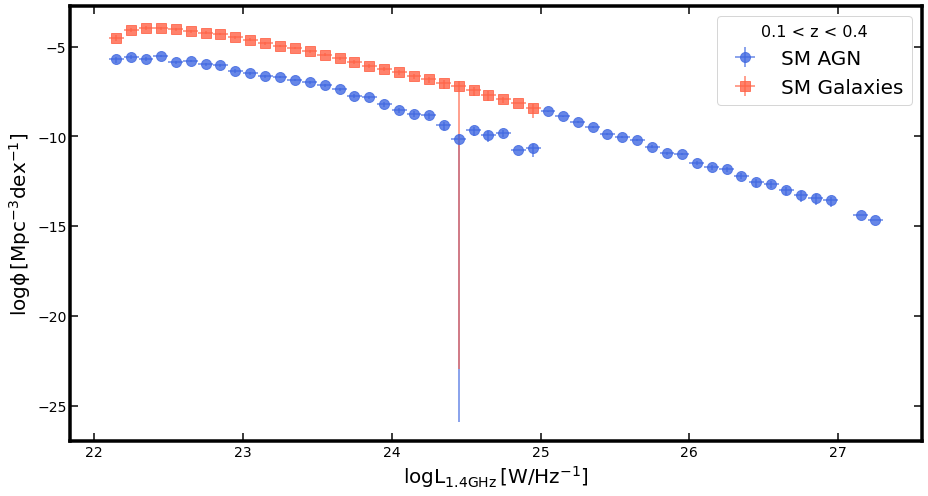

In [118]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

y_errs = np.array([np.log10(SM_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
         np.log10(SM_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex -\
                  np.sqrt(SM_AGN_sumed_bins_z0.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex),\
          np.log10(np.sqrt(SM_AGN_sumed_bins_z0.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex +\
                   SM_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
          np.log10(SM_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex)])

ax1.errorbar(np.log10(cut_bins_SM[:-1]) + bins_size_dex / 2, np.log10(SM_AGN_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                      bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='o', ls='',\
             label='SM AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_SM[:-1]) + bins_size_dex / 2, np.log10(SM_gal_sumed_bins_z0.loc[:, '1_vmax'].to_numpy() /\
                                                                      bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='s', ls='',\
             label='SM Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='0.1 < z < 0.4', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

divide by zero encountered in log10
invalid value encountered in subtract
divide by zero encountered in log10
divide by zero encountered in log10


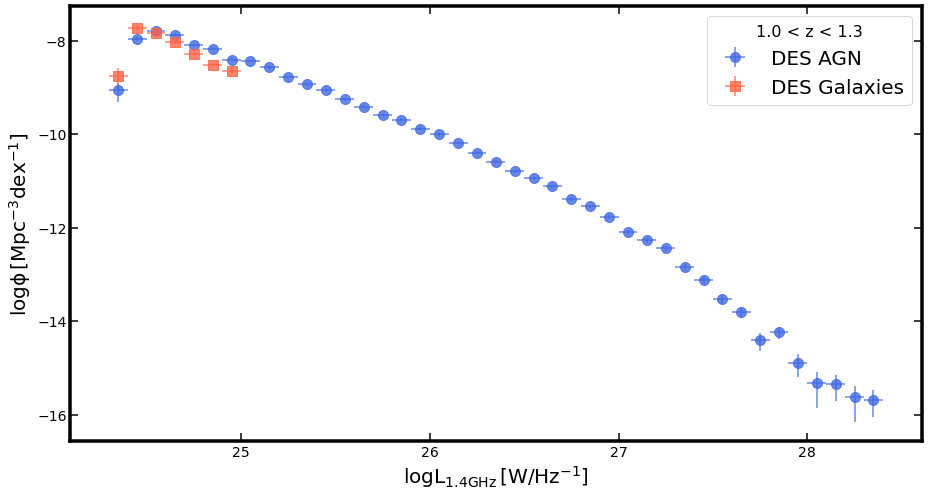

In [119]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

y_errs = np.array([np.log10(DES_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
         np.log10(DES_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex -\
                  np.sqrt(DES_AGN_sumed_bins_z1.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex),\
          np.log10(np.sqrt(DES_AGN_sumed_bins_z1.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex +\
                   DES_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
          np.log10(DES_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex)])

ax1.errorbar(np.log10(cut_bins_DES[:-1]) + bins_size_dex / 2, np.log10(DES_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='o', ls='',\
             label='DES AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_DES[:-1]) + bins_size_dex / 2, np.log10(DES_gal_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='s', ls='',\
             label='DES Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='1.0 < z < 1.3', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

divide by zero encountered in log10
invalid value encountered in subtract
divide by zero encountered in log10
divide by zero encountered in log10


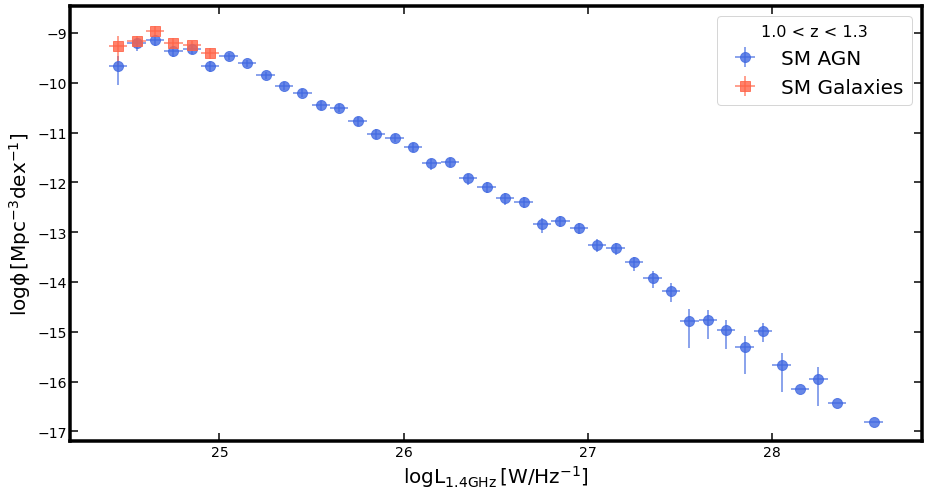

In [120]:
fig             = plt.figure(figsize=(13,7))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

y_errs = np.array([np.log10(SM_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
         np.log10(SM_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex -\
                  np.sqrt(SM_AGN_sumed_bins_z1.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex),\
          np.log10(np.sqrt(SM_AGN_sumed_bins_z1.loc[:, '1_vmax2'].to_numpy()) /\
                                                                       bins_size_dex +\
                   SM_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex) -\
          np.log10(SM_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                       bins_size_dex)])

ax1.errorbar(np.log10(cut_bins_SM[:-1]) + bins_size_dex / 2, np.log10(SM_AGN_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                      bins_size_dex),\
              xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='o', ls='',\
             label='SM AGN', ms=10, color='royalblue', alpha=0.8)
ax1.errorbar(np.log10(cut_bins_SM[:-1]) + bins_size_dex / 2, np.log10(SM_gal_sumed_bins_z1.loc[:, '1_vmax'].to_numpy() /\
                                                                      bins_size_dex), xerr=bins_size_dex / 2, yerr=y_errs * 1e0, marker='s', ls='',\
             label='SM Galaxies', ms=10, color='tomato', alpha=0.8)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$\log{}\mathrm{L}_{1.4 \mathrm{GHz}}\, [\mathrm{W}/\mathrm{Hz}^{-1}]$', size=20)
ax1.set_ylabel('$\log{}\mathrm{\phi}\, [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=1, fontsize=20, title='1.0 < z < 1.3', title_fontsize=16)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()